In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import ParameterGrid, train_test_split
from matplotlib import pyplot as plt

In [ ]:
# --- Load CSV from Google Drive ---
def load_gdrive_csv(view_url):
    file_id = view_url.split('/')[-2]
    url = f'https://drive.google.com/uc?id={file_id}'
    return pd.read_csv(url, on_bad_lines='skip')

train_df = load_gdrive_csv('https://drive.google.com/file/d/1CopYz6AN8OxZ2WrX5F6E7cKp9T3CNFIr/view?usp=drive_link')
test_df = load_gdrive_csv('https://drive.google.com/file/d/135rLDPo6kVMBY4NFsz9VmECd-AwqUeFH/view?usp=drive_link')

In [ ]:
# --- Preprocessing ---
train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])
train_df.set_index('Date', inplace=True)
test_df.set_index('Date', inplace=True)

In [ ]:
features = ['Price', 'Open', 'High', 'Low', 'Change %']
target_col = 'Price'
target_index = features.index(target_col)

In [ ]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df[features])
test_scaled = scaler.transform(test_df[features])

In [ ]:
# --- Create sequences for single-step forecasting ---
window_size = 60
forecast_horizon = 1  # chỉ dự báo 1 bước tiếp theo

def create_sequences(data, window_size, target_index):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size, target_index])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_scaled, window_size, target_index)
X_test, y_test = create_sequences(test_scaled, window_size, target_index)

print(f"Training shape: {X_train.shape}, {y_train.shape}")
print(f"Testing shape: {X_test.shape}, {y_test.shape}")

Training shape: (3104, 60, 5), (3104,)
Testing shape: (732, 60, 5), (732,)


In [ ]:
# --- Build LSTM model ---
def build_lstm_model(units, dropout_rate, learning_rate, input_shape):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(units),
        Dropout(dropout_rate),
        Dense(1)
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')
    return model


In [ ]:
# --- Evaluation function ---
def evaluate(y_true, y_pred):
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    mae = mean_absolute_error(y_true_flat, y_pred_flat)
    mse = mean_squared_error(y_true_flat, y_pred_flat)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true_flat - y_pred_flat) / y_true_flat)) * 100
    r2 = r2_score(y_true_flat, y_pred_flat)

    return mae, mse, rmse, mape, r2

In [ ]:
val_size = int(len(X_train) * 0.1)
X_train_sub, X_val = X_train[:-val_size], X_train[-val_size:]
y_train_sub, y_val = y_train[:-val_size], y_train[-val_size:]

In [ ]:
# --- Hyperparameter tuning ---
param_grid = {
    'units': [64, 32],
    'learning_rate': [0.001, 0.005],
    'dropout_rate': [0.1, 0.2],
    'batch_size': [32, 64],
    'epochs': [50, 100]
}

best_val_loss = np.inf
best_params = None
best_model = None

for params in ParameterGrid(param_grid):
    print(f"\nTraining with params: {params}")
    model = build_lstm_model(
        units=params['units'],
        dropout_rate=params['dropout_rate'],
        learning_rate=params['learning_rate'],
        input_shape=(window_size, len(features))
    )

    history = model.fit(
        X_train_sub, y_train_sub,
        validation_data=(X_val, y_val),
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        verbose=0,
        callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
    )

    val_loss = min(history.history['val_loss'])
    print(f" → Validation loss: {val_loss:.6f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_params = params
        best_model = model

print(f"\nBest params: {best_params}")
print(f"Best validation loss: {best_val_loss:.6f}")


Training with params: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 50, 'learning_rate': 0.001, 'units': 64}
 → Validation loss: 0.000080

Training with params: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 50, 'learning_rate': 0.001, 'units': 32}
 → Validation loss: 0.000087

Training with params: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 50, 'learning_rate': 0.005, 'units': 64}
 → Validation loss: 0.000083

Training with params: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 50, 'learning_rate': 0.005, 'units': 32}
 → Validation loss: 0.000084

Training with params: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.001, 'units': 64}
 → Validation loss: 0.000082

Training with params: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.001, 'units': 32}
 → Validation loss: 0.000084

Training with params: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 100, 'learning_rate': 0.005, 'units': 64}
 → Validation loss: 0.000

In [ ]:
print("\nModel Architecture:")
best_model.summary()


Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,957 (210.77 KB)

 Trainable params: 17,985 (70.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 35,972 (140.52 KB)

In [ ]:
# --- Kết hợp 60 ngày cuối từ train_df với test_df ---
last_60_train = train_df[features].iloc[-window_size:]
combined_test_input = pd.concat([last_60_train, test_df[features]], axis=0)

# --- Scale dữ liệu ---
combined_scaled = scaler.transform(combined_test_input)

# --- Tạo sequence ---
X_test_final, y_test_final = create_sequences(combined_scaled, window_size, target_index)

# --- Dự báo ---
y_pred = best_model.predict(X_test_final)

# --- Hàm inverse scale ---
def inverse_transform_single_column(preds, target_index, scaler, feature_len):
    dummy = np.zeros((len(preds), feature_len))
    dummy[:, target_index] = preds.flatten()
    return scaler.inverse_transform(dummy)[:, target_index]

# --- Scale ngược kết quả ---
y_test_inv = inverse_transform_single_column(y_test_final, target_index, scaler, len(features))
y_pred_inv = inverse_transform_single_column(y_pred, target_index, scaler, len(features))

# --- Đánh giá ---
mae, mse, rmse, mape, r2 = evaluate(y_test_inv, y_pred_inv)
print("\n--- Test Evaluation ---")
print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²:   {r2:.4f}")


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step

--- Test Evaluation ---
MAE:  0.0079
MSE:  0.0001
RMSE: 0.0103
MAPE: 0.53%
R²:   0.9704


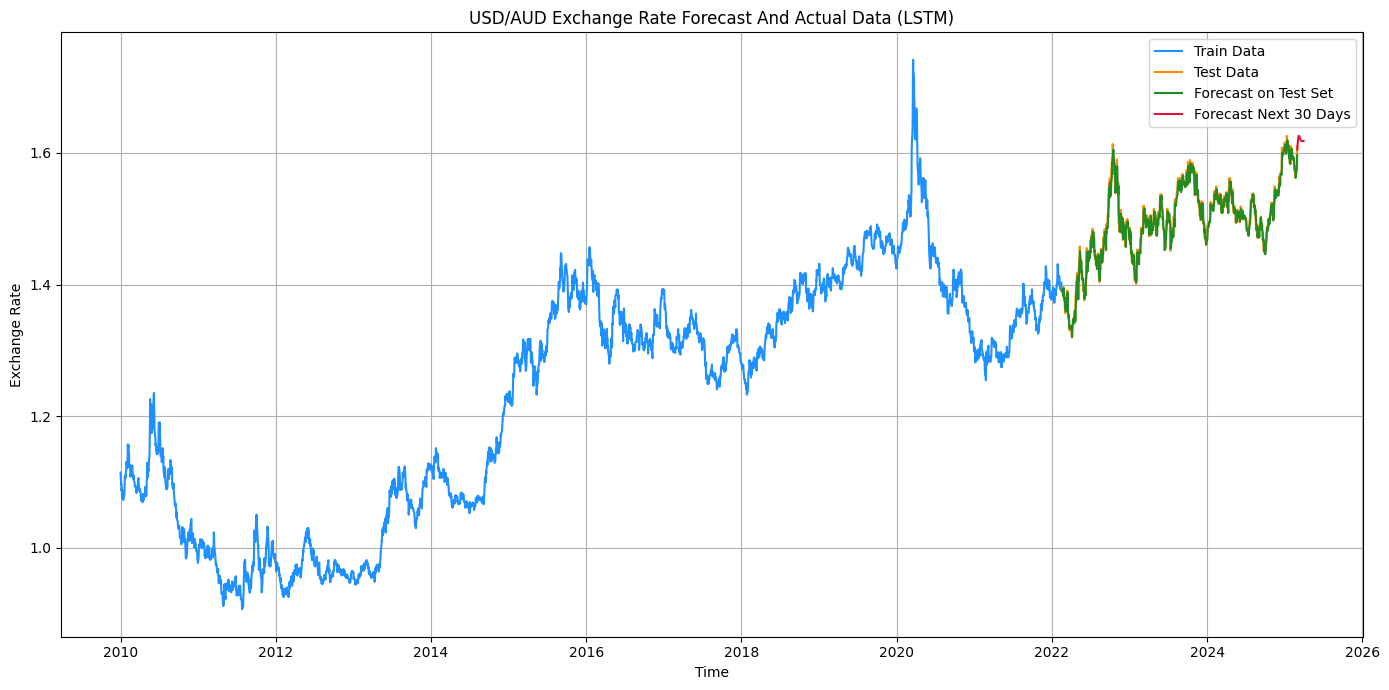

In [ ]:
# --- Dự báo 30 ngày tương lai ---
last_60_days = test_df[features].iloc[-window_size:].copy()
last_60_scaled = scaler.transform(last_60_days)

forecast_input = last_60_scaled.copy()
forecast_predictions = []

for _ in range(30):
    input_seq = forecast_input[-window_size:].reshape(1, window_size, len(features))
    next_pred_scaled = best_model.predict(input_seq, verbose=0)[0, 0]

    last_known_row = forecast_input[-1].copy()
    last_known_row[target_index] = next_pred_scaled
    forecast_input = np.vstack([forecast_input, last_known_row])

    forecast_predictions.append(next_pred_scaled)

forecast_predictions = np.array(forecast_predictions)
forecast_inv = inverse_transform_single_column(forecast_predictions, target_index, scaler, len(features))

# --- Tạo index ngày tương lai ---
last_date = test_df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')

# --- Vẽ tổng hợp ---
plt.figure(figsize=(14, 7))
plt.plot(train_df.index, train_df['Price'], label='Train Data', color='dodgerblue')
plt.plot(test_df.index, test_df['Price'], label='Test Data', color='darkorange')
plt.plot(test_df.index, y_pred_inv, label='Forecast on Test Set', color='forestgreen')
plt.plot(future_dates, forecast_inv, label='Forecast Next 30 Days', color='crimson')

plt.title('USD/AUD Exchange Rate Forecast And Actual Data (LSTM)')
plt.xlabel('Time')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


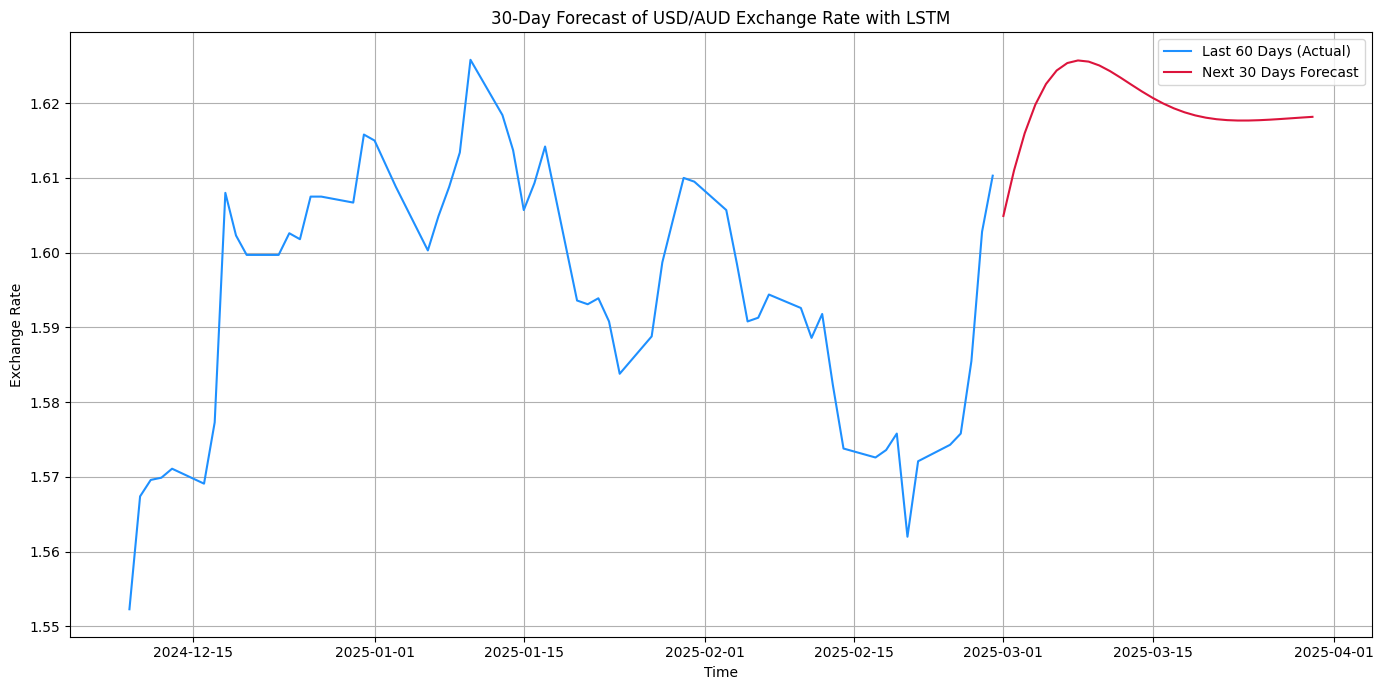

In [ ]:
# --- Zoom biểu đồ ---
last_60_actual = test_df['Price'].values[-60:]
last_60_dates = test_df.index[-60:]

plt.figure(figsize=(14, 7))
plt.plot(last_60_dates, last_60_actual, label='Last 60 Days (Actual)', color='dodgerblue')
plt.plot(future_dates, forecast_inv, label='Next 30 Days Forecast', color='crimson')

plt.title('30-Day Forecast of USD/AUD Exchange Rate with LSTM')
plt.xlabel('Time')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
